# Chest X-Ray Medical Diagnosis with Deep Learning

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
pwd

'/content'

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.models import load_model

import util

In [26]:
import tensorflow as tf

In [27]:
tf.__version__

'2.4.1'

In [28]:
path='/content/drive/MyDrive/'

In [2]:
train_df = pd.read_csv("nih/train-small.csv")
valid_df = pd.read_csv("nih/valid-small.csv")

test_df = pd.read_csv("nih/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
test_df

,Image,PatientId,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021463_005.png,21463,0,0,1,1,1,0,0,1,0,0,0,0,1,0
1,00019733_002.png,19733,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,00021463_001.png,21463,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00017136_020.png,17136,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,00027477_000.png,27477,0,0,0,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,00010497_000.png,10497,0,0,0,0,0,1,0,0,0,0,0,0,0,0
416,00017262_001.png,17262,0,0,0,0,0,1,0,0,0,0,0,0,0,0
417,00021653_000.png,21653,0,0,0,0,0,1,0,0,0,1,0,0,0,0
418,00017243_001.png,17243,0,0,0,0,0,1,0,0,1,1,0,0,0,0


In [30]:
train_df.iloc[0,:]

Image                 00008270_015.png
Atelectasis                          0
Cardiomegaly                         0
Consolidation                        0
Edema                                0
Effusion                             0
Emphysema                            0
Fibrosis                             0
Hernia                               0
Infiltration                         0
Mass                                 0
Nodule                               0
PatientId                         8270
Pleural_Thickening                   0
Pneumonia                            0
Pneumothorax                         0
Name: 0, dtype: object

In [31]:
test_df.iloc[0,:]

Image                 00021463_005.png
PatientId                        21463
Cardiomegaly                         0
Emphysema                            0
Effusion                             1
Hernia                               1
Infiltration                         1
Mass                                 0
Nodule                               0
Atelectasis                          1
Pneumothorax                         0
Pleural_Thickening                   0
Pneumonia                            0
Fibrosis                             0
Edema                                1
Consolidation                        0
Name: 0, dtype: object

In [5]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-1'></a>
### 2.1 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [33]:

def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 : dataframe describing first dataset
        df2 (: dataframe describing second dataset
        patient_col : string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    
    leakage = len(patients_in_both_groups) > 0 
    
   
    
    return leakage

In [34]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


If we get `False` for both, then we're ready to start preparing the datasets for training. Remember to always check for data leakage!

In [7]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df : dataframe specifying training data.
      image_dir : directory where image files are held.
      x_col : name of column in df that holds filenames.
      y_cols : list of strings that hold y labels for images.
      sample_size : size of sample to use for normalization statistics.
      batch_size : images per batch to be fed into model during training.
      seed : random seed.
      target_w : final width of input images.
      target_h : final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
   
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [8]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df : dataframe specifying validation data.
      test_df : dataframe specifying test data.
      train_df : dataframe specifying training data.
      image_dir : directory where image files are held.
      x_col : name of column in df that holds filenames.
      y_cols : list of strings that hold y labels for images.
      sample_size : size of sample to use for normalization statistics.
      batch_size : images per batch to be fed into model during training.
      seed : random seed.
      target_w : final width of input images.
      target_h : final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
   
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    
    batch = raw_train_generator.next()
    data_sample = batch[0]

   
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
  
    image_generator.fit(data_sample)

    
    
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [9]:
IMAGE_DIR = "nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 1 validated image filenames.
Found 420 validated image filenames.


/home/omkar/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Let's peek into what the generator gives our model during training and validation. We can do this by calling the `__get_item__(index)` function:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


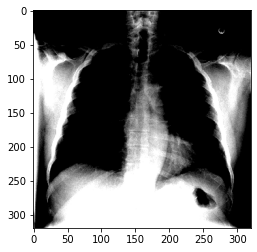

In [80]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

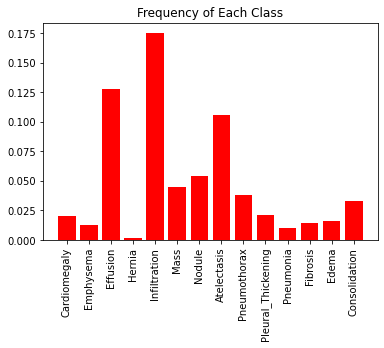

In [10]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0),color=['red'])
plt.title("Frequency of Each Class")
plt.show() 

In [12]:

def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels : matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies : array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies : array of negative frequences for each
                                         class, size (num_classes)"""
    
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    
    return positive_frequencies, negative_frequencies

Now we'll compute frequencies for our training data.

In [13]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

Let's visualize these two contribution ratios next to each other for each of the pathologies:

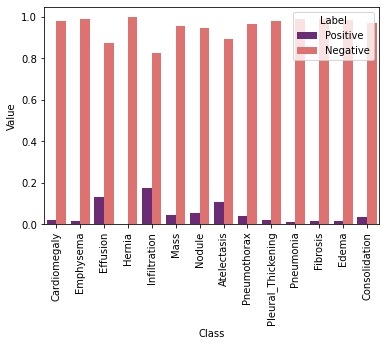

In [18]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data,palette = 'magma')

In [20]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other again:

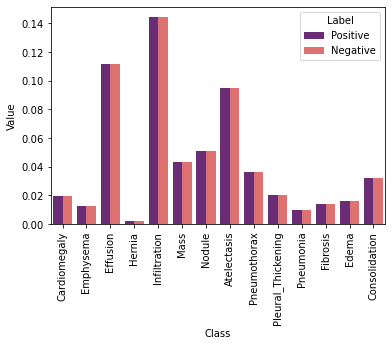

In [21]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data,palette = 'magma');

In [87]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights : array of positive weights for each class, size (num_classes)
      neg_weights : array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true : Tensor of true labels, size is (num_examples, num_classes)
            y_pred : Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss : overall scalar loss summed across all classes
        """
        
        loss = 0.0
        
        
        y_true=tf.cast(y_true,dtype='float32')
        y_pred=tf.cast(y_pred,dtype='float32')
        for i in range(len(pos_weights)):
           
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            d=0
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    
        
    return weighted_loss

Now let's test our function with some simple cases. 

In [89]:
# create the base pre-trained model
base_model = DenseNet121(weights=None, include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights('/content/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights),metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 34s 214ms/step - loss: 2.9339 - binary_accuracy: 0.8948 - val_loss: 0.4718 - val_binary_accuracy: 1.0000
Epoch 2/100
100/100 [==============================] - 20s 196ms/step - loss: 0.8316 - binary_accuracy: 0.7055
Epoch 3/100
100/100 [==============================] - 20s 195ms/step - loss: 0.6781 - binary_accuracy: 0.6658
Epoch 4/100
100/100 [==============================] - 20s 194ms/step - loss: 0.5816 - binary_accuracy: 0.7095
Epoch 5/100
100/100 [==============================] - 20s 195ms/step - loss: 0.5333 - binary_accuracy: 0.7468
Epoch 6/100
100/100 [==============================] - 20s 195ms/step - loss: 0.4552 - binary_accuracy: 0.7640
Epoch 7/100
100/100 [==============================] - 20s 195ms/step - loss: 0.4255 - binary_accuracy: 0.7849
Epoch 8/100
100/100 [==============================] - 19s 194ms/step - loss: 0.4206 - binary_accuracy: 0.7913
Epoch 9/100
100/100 [==============================] - 19s 194m

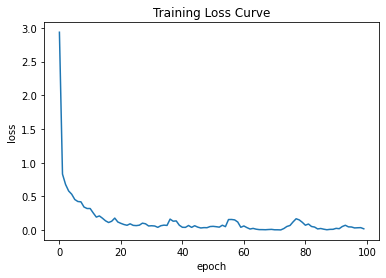

In [90]:
"""
OPTIONAL: uncomment this code to practice training the model.
This is optional because you will load pre-trained weights after this.
"""
history = model.fit_generator(train_generator, 
                               validation_data=valid_generator,
                               steps_per_epoch=100, 
                               validation_steps=25,epochs = 100)
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [91]:
model.save(path+'model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model1/assets


In [1]:
!ls

 00000013_005.png	   index.jpeg			 static
 00000334_005.png	   logs				 templates
 00029855_001.png	   model			 Untitled.ipynb
 25-01-2020_flask_csv.py   model1-20210617T040125Z-001	 upload_image
 app.py			   new_sample_lables.csv	 util.py
 C1M1_Assignment.ipynb	   nih				 x_pro.ipynb
 chest-example2.png	  'ppt image'			 xray1.pdf
 Densenet_model.h5	   __pycache__			 xray.pdf
 Inceptionmodel.h5	   sample


In [2]:
import tensorflow as tf

In [3]:
model=tf.keras.models.load_model('model1',compile=False)

In [4]:
import cv2

In [5]:
img=cv2.imread('00029855_001.png')

In [6]:
img=cv2.resize(img,(320,320))

In [7]:
img=img.reshape((-1,320,320,3))

In [8]:
img=img/255.0

In [9]:
p=model.predict(img)

In [10]:
p

array([[9.5594078e-02, 5.8493018e-04, 9.4682282e-01, 2.6360750e-03,
        6.6948074e-01, 4.4245422e-03, 3.9317556e-06, 9.4228590e-01,
        1.0659846e-04, 1.3945264e-01, 9.3336141e-01, 2.1508336e-04,
        5.5005580e-02, 2.9510856e-02]], dtype=float32)

In [11]:
import decimal

In [15]:
tmp=[decimal.Decimal(str(i)) for i in p[0]]

In [25]:
tmp=[float(str(i)) for i in p[0]]

In [26]:
tmp

[0.09559408,
 0.0005849302,
 0.9468228,
 0.002636075,
 0.66948074,
 0.004424542,
 3.9317556e-06,
 0.9422859,
 0.00010659846,
 0.13945264,
 0.9333614,
 0.00021508336,
 0.05500558,
 0.029510856]

In [12]:
for i in p[0]:
    num=str(i)
    tmp = decimal.Decimal(num)
    print( tmp)

0.09559408
0.0005849302
0.9468228
0.002636075
0.66948074
0.004424542
0.0000039317556
0.9422859
0.00010659846
0.13945264
0.9333614
0.00021508336
0.05500558
0.029510856


In [27]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [28]:
l=dict(zip(labels,tmp))

In [29]:
l

{'Cardiomegaly': 0.09559408,
 'Emphysema': 0.0005849302,
 'Effusion': 0.9468228,
 'Hernia': 0.002636075,
 'Infiltration': 0.66948074,
 'Mass': 0.004424542,
 'Nodule': 3.9317556e-06,
 'Atelectasis': 0.9422859,
 'Pneumothorax': 0.00010659846,
 'Pleural_Thickening': 0.13945264,
 'Pneumonia': 0.9333614,
 'Fibrosis': 0.00021508336,
 'Edema': 0.05500558,
 'Consolidation': 0.029510856}

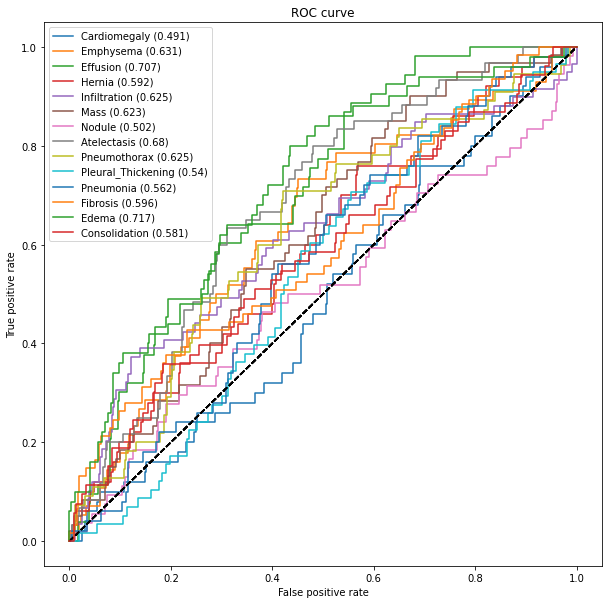

In [95]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)